<a href="https://colab.research.google.com/github/alexshibu1/ML-projects/blob/main/Copy_of_Prompt_based_Image_In_Painting_powered_by_ClipSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git lfs install

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


In [2]:
! git clone https://github.com/timojl/clipseg 

Cloning into 'clipseg'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 226 (delta 66), reused 51 (delta 51), pack-reused 141
Receiving objects: 100% (226/226), 1.40 MiB | 23.81 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [3]:
! pip install diffusers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.0/852.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 9.2 MB/s eta 0:00:00


In [4]:
! pip install transformers -q -UU ftfy gradio  

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.5 MB/s eta 0:00:

In [5]:
! pip install git+https://github.com/openai/CLIP.git -q

  Preparing metadata (setup.py) ... done


In [6]:
from huggingface_hub import notebook_login

notebook_login()

In [7]:
%cd clipseg

/content/clipseg


In [8]:
! ls

datasets	     metrics.py		      score.py
environment.yml      models		      setup.py
evaluation_utils.py  overview.png	      supplementary.pdf
example_image.jpg    Quickstart.ipynb	      Tables.ipynb
experiments	     README.md		      training.py
general_utils.py     sample_rd64.png	      Visual_Feature_Engineering.ipynb
LICENSE		     sample_rd64_refined.png


In [9]:
import torch
import requests
import cv2 
from models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

In [10]:
from io import BytesIO

from torch import autocast
import requests
import PIL
import torch
from diffusers import StableDiffusionInpaintPipeline as StableDiffusionInpaintPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [11]:
#! git lfs install

In [12]:
# load model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();


100%|███████████████████████████████████████| 335M/335M [00:07<00:00, 48.2MiB/s]


In [19]:
# non-strict, because we only stored decoder weights (not CLIP weights)
model.load_state_dict(torch.load('/content/clipseg/weights/rd64-uni.pth', map_location=torch.device('cuda')), strict=False);


FileNotFoundError: ignored

In [18]:
device = "cuda"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/diffusers/pipelines/pipeline_utils.py:914: FutureWarning: You are using a legacy checkpoint for inpainting with Stable Diffusion, therefore we are loading the <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> class instead of <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'>. For better inpainting results, we strongly suggest using Stable Diffusion's official inpainting checkpoint: https://huggingface.co/runwayml/stable-diffusion-inpainting instead or adapting your checkpoint CompVis/stable-diffusion-v1-4 to the format of https://huggingface.co/runwayml/stable-diffusion-inpainting. Note that we do not actively maintain the {StableDiffusionInpaintPipelineLegacy} class and will likely remove it in version 1.0.0.
  deprecate("StableDiffusionInpaintPipelineLegacy", "1.0.0", deprecation_message, standard_warn=False)
C

In [17]:
# or load from URL...
image_url = 'https://okmagazine.ge/wp-content/uploads/2021/04/00-promo-rob-pattison-1024x1024.jpg' #'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimage.tmdb.org%2Ft%2Fp%2Foriginal%2F72xYNWRTVMDiKVa6SVu6EY0S9Np.jpg' #'https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png' 
input_image = Image.open(requests.get(image_url, stream=True).raw)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((512, 512)),
])
img = transform(input_image).unsqueeze(0)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [20]:
%cd ..

/content


In [21]:
input_image.convert("RGB").resize((512, 512)).save("init_image.png", "PNG")

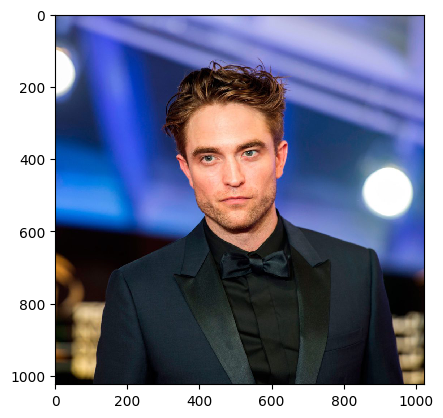

In [22]:
from matplotlib import pyplot as plt
plt.imshow(input_image, interpolation='nearest')
plt.show()

In [23]:
prompts = ['shirt']

In [24]:

# predict
with torch.no_grad():
    preds = model(img.repeat(len(prompts),1,1,1), prompts)[0]


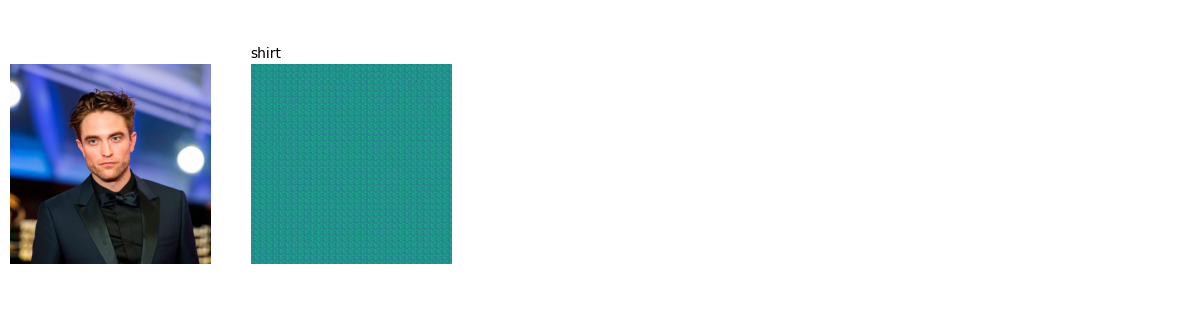

In [25]:
# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompts[i]) for i in range(len(prompts))];

In [26]:
filename = f"mask.png"
plt.imsave(filename,torch.sigmoid(preds[0][0]))

In [27]:
img2 = cv2.imread(filename)

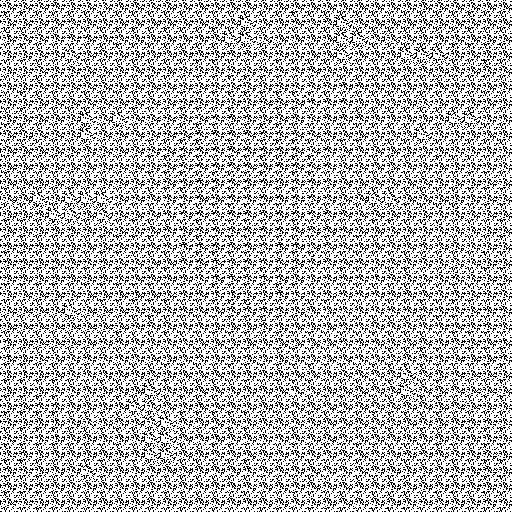

In [28]:
gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

(thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

# For debugging only:
cv2.imwrite(filename,bw_image)

# fix color format
cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

Image.fromarray(bw_image)

In [29]:
init_image = Image.open('init_image.png')
mask = Image.open('mask.png')

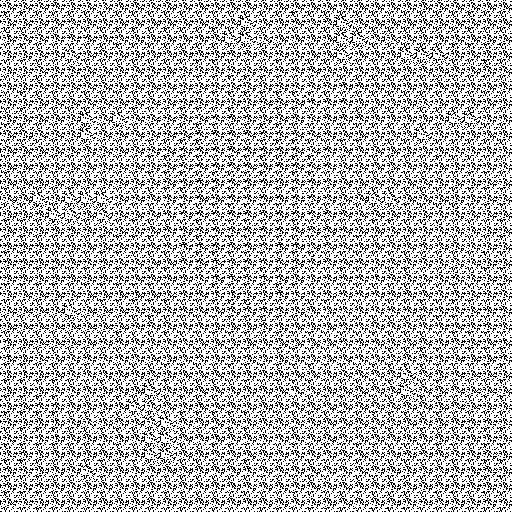

In [30]:
mask

In [32]:
with autocast("cuda"):
    images = pipe(prompt="a yellow flowered holiday shirt", init_image=init_image, mask_image=mask, strength=0.8)["sample"]


TypeError: ignored

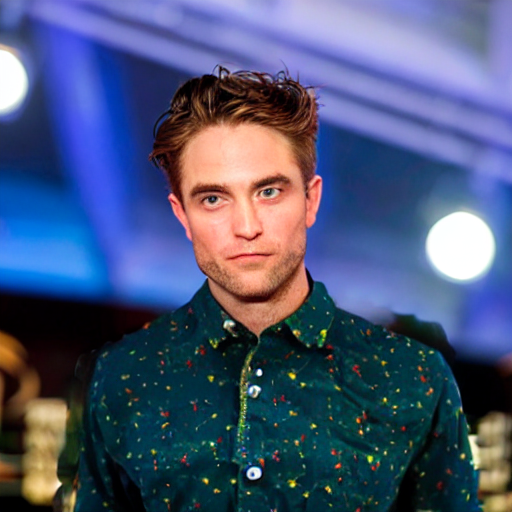

In [ ]:
images[0]